In [1]:
import sys

sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain")
sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain\\source")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.loftr.backbone import ResNetFPN_32_8
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange
from torchvision.transforms import v2
from source.data_processing.image_reading import read_image
from torchvision.transforms import ToTensor
from source.data_processing.keypoints import translate_patch_midpoints_and_refine
import matplotlib.pyplot as plt
import numpy as np
from source.miscellaneous.evaluation import load_deformation
from source.visualization.image_visualization import plot_image_with_crop, plot_images_with_matches_via_mapping, plot_images_with_keypoint_matches
from kornia.geometry.ransac import RANSAC

In [3]:
patch_size = 32
confidence_threshold = 0.95
attention_type = "linear"
model_name = "8"
block_dimensions = [32, 64, 96, 128, 192]
fine_feature_size = block_dimensions[2]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_32_8(block_dimensions=block_dimensions).cuda()
state_dict_backbone = torch.load(f"../../models/coarse_matching/{model_name}/backbone.pt")
state_dict_backbone = {k.replace("module.", ""): v for k, v in state_dict_backbone.items()}
backbone.load_state_dict(state_dict_backbone)

positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
    attention_type=attention_type
).cuda()
state_dict_coarse_loftr = torch.load(f"../../models/coarse_matching/{model_name}/coarse_loftr.pt")
state_dict_coarse_loftr = {k.replace("module.", ""): v for k, v in state_dict_coarse_loftr.items()}
coarse_loftr.load_state_dict(state_dict_coarse_loftr)

coarse_matcher = CoarseMatching(
    temperature=0.1, confidence_threshold=confidence_threshold
).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
    attention_type=attention_type
).cuda()
state_dict_fine_loftr = torch.load(f"../../models/coarse_matching/{model_name}/fine_loftr.pt")
state_dict_fine_loftr = {k.replace("module.", ""): v for k, v in state_dict_fine_loftr.items()}
fine_loftr.load_state_dict(state_dict_fine_loftr)

fine_matching = FineMatching().cuda()

In [4]:
image_1 = read_image("../../data/cyto_test_downscaled_10x/B20_0526_Slice15.tif")
image_2 = read_image("../../data/cyto_test_downscaled_10x/B20_0527_Slice15.tif")
image_1, image_2 = ToTensor()(image_1), ToTensor()(image_2)

image_1, image_2 = v2.Normalize(mean=[0.594], std=[0.204])(image_1), v2.Normalize(mean=[0.594], std=[0.204])(image_2)

In [5]:
image_1.size(), image_2.size()

(torch.Size([1, 7440, 3533]), torch.Size([1, 7400, 3514]))

In [6]:
crop_size = 1280
divider = 1  # If more overlap is desired, increase this number

image_1_x_num_windows = np.ceil(image_1.shape[2]/(crop_size/divider))
image_1_x_step_size = int((image_1.shape[2] - crop_size) / (image_1_x_num_windows - 1))

image_1_y_num_windows = np.ceil(image_1.shape[1]/(crop_size/divider))
image_1_y_step_size = int((image_1.shape[1] - crop_size) / (image_1_y_num_windows - 1))

image_2_x_num_windows = np.ceil(image_2.shape[2]/(crop_size/divider))
image_2_x_step_size = int((image_2.shape[2] - crop_size) / (image_2_x_num_windows - 1))

image_2_y_num_windows = np.ceil(image_2.shape[1]/(crop_size/divider))
image_2_y_step_size = int((image_2.shape[1] - crop_size) / (image_2_y_num_windows - 1))

In [7]:
image_1_crops = {}
image_2_crops = {}

for x in range(0, int(image_1_x_num_windows)):    
    for y in range(0, int(image_1_y_num_windows)):
        image_1_crops[f"{x*image_1_x_step_size}, \
                      {y*image_1_y_step_size}"] = image_1[:, y*image_1_y_step_size:y*image_1_y_step_size+crop_size,
                                                          x*image_1_x_step_size:x*image_1_x_step_size+crop_size]
        
for x in range(0, int(image_2_x_num_windows)):    
    for y in range(0, int(image_2_y_num_windows)):
        image_2_crops[f"{x*image_2_x_step_size}, \
                      {y*image_2_y_step_size}"] = image_2[:, y*image_2_y_step_size:y*image_2_y_step_size+crop_size,
                                                          x*image_2_x_step_size:x*image_2_x_step_size+crop_size]

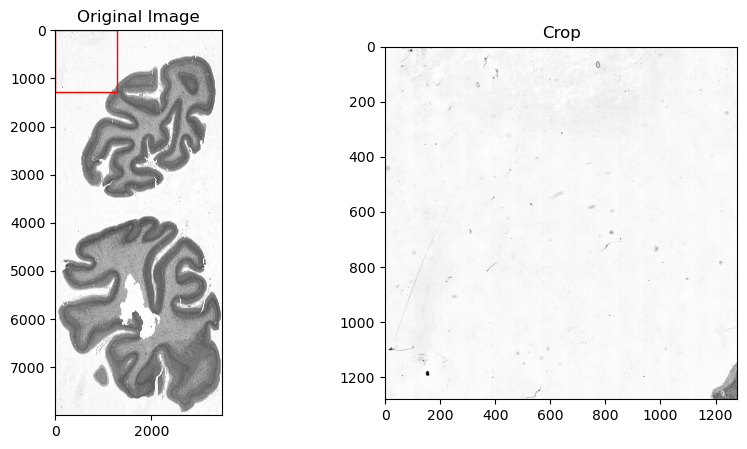

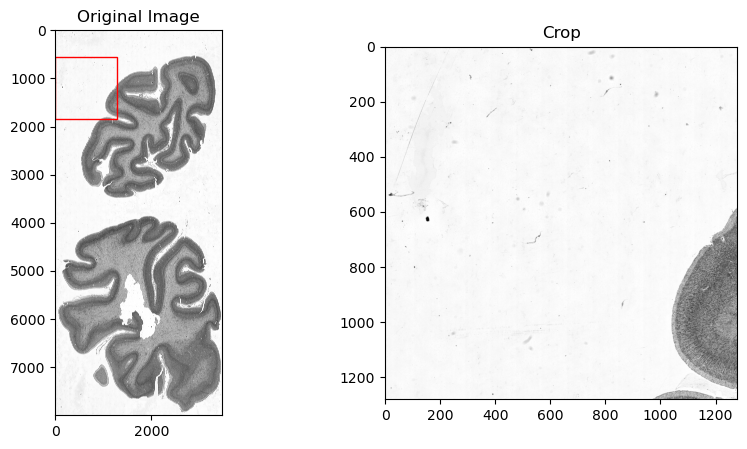

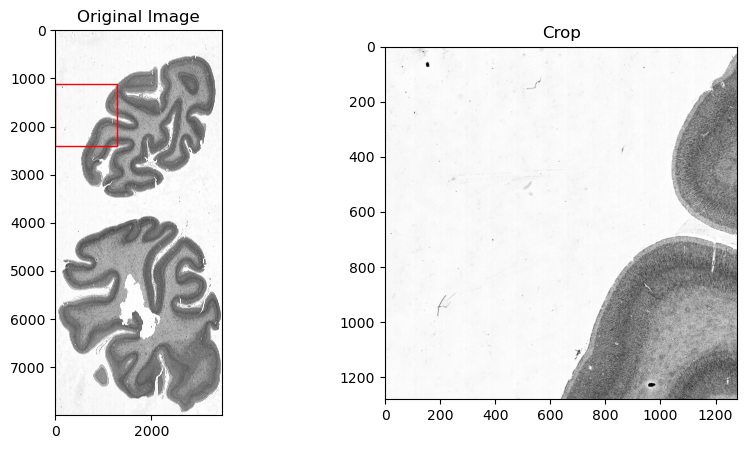

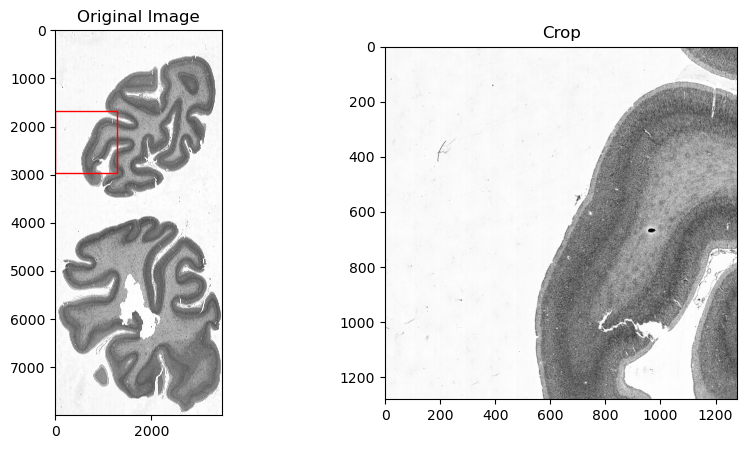

KeyboardInterrupt: 

In [8]:
for position, crop in image_1_crops.items():    
    plot_image_with_crop(image_1, crop, [int(i) for i in position.split(", ")])

In [9]:
# for position, crop in image_2_crops.items():    
#     plot_image_with_crop(image_2, crop, [int(i) for i in position.split(", ")])

In [10]:
deformation = load_deformation()

In [11]:
deformation.shape[:-1], image_1.shape[1:]

(torch.Size([8000, 3463]), torch.Size([8000, 3462]))

In [8]:
image_1_visualization_adjusted = torch.concatenate((image_1, torch.zeros(1, 8000, 205)), dim=2)
# deformation_visualization_adjusted = torch.concatenate(
#     (torch.Tensor(deformation), torch.ones(8000, 205, 2) * -1), dim=1
# )
image_2_visualization_adjusted = torch.concatenate((image_2, torch.zeros(1, 618, 3668)), dim=1)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 7440 but got size 8000 for tensor number 1 in the list.

In [ ]:
image_1_visualization_adjusted.shape, image_2_visualization_adjusted.shape

(torch.Size([1, 8000, 3667]), torch.Size([1, 8000, 3668]))

In [13]:
# plot_images_with_matches_via_mapping(image_1_visualization_adjusted, image_2_visualization_adjusted, 
#                                      deformation_visualization_adjusted, number_of_matches=20, sample_keypoints_randomly=True)

In [14]:
# index = [3000, 500]

# # Create a figure with two subplots
# fig, axs = plt.subplots(1, 2)

# # Plot img1_ds_np in the first subplot
# axs[0].imshow(image_1[0], cmap="gray")
# axs[0].scatter(index[0], index[1])
# axs[0].set_title("Image 1")


# # Plot img2_ds_np in the second subplot
# axs[1].imshow(image_2[0], cmap="gray")
# axs[1].scatter(*deformation[index[1], index[0]])
# axs[1].set_title("Image 2")

In [15]:
# from source.visualization.image_visualization import plot_images_in_row
# plot_images_in_row([crop_1[0], crop_2[0]])

In [9]:
matches_image_1 = []
matches_image_2 = []

with torch.no_grad():
    for coordinates_1, crop_1 in image_1_crops.items():
        for coordinates_2, crop_2 in image_2_crops.items():

            coarse_image_feature_1, fine_image_feature_1 = backbone(crop_1.cuda().unsqueeze(0))
            coarse_image_feature_2, fine_image_feature_2 = backbone(crop_2.cuda().unsqueeze(0))

            fine_height_width = fine_image_feature_1.shape[-1]
            coarse_height_width = coarse_image_feature_1.shape[-1]

            coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
            coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

            coarse_image_feature_1 = rearrange(
                coarse_image_feature_1, "n c h w -> n (h w) c"
            )
            coarse_image_feature_2 = rearrange(
                coarse_image_feature_2, "n c h w -> n (h w) c"
            )

            coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
                coarse_image_feature_1, coarse_image_feature_2
            )

            coarse_matches_predicted = coarse_matcher(
                coarse_image_feature_1, coarse_image_feature_2
            )
            match_matrix_predicted = coarse_matches_predicted["match_matrix"]

            (
                fine_image_feature_1_unfold,
                fine_image_feature_2_unfold,
            ) = fine_preprocess(
                coarse_image_feature_1=coarse_image_feature_1,
                coarse_image_feature_2=coarse_image_feature_2,
                fine_image_feature_1=fine_image_feature_1,
                fine_image_feature_2=fine_image_feature_2,
                coarse_matches=coarse_matches_predicted,
                fine_height_width=fine_height_width,
                coarse_height_width=coarse_height_width
            )

            # Skip crops that do not contain any matches
            if fine_image_feature_1_unfold.size(0) == 0:
                continue

            fine_image_feature_1_unfold = fine_image_feature_1_unfold.to("cuda")
            fine_image_feature_2_unfold = fine_image_feature_2_unfold.to("cuda")


            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(fine_image_feature_1_unfold, fine_image_feature_2_unfold)



            predicted_relative_coordinates = fine_matching(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            match_matrix_predicted = match_matrix_predicted.cpu()
            predicted_relative_coordinates = predicted_relative_coordinates.cpu()

            (
                crop_1_patch_mid_coordinates,
                crop_2_patch_mid_coordinates,
                crop_2_patch_mid_coordinates_refined,
            ) = translate_patch_midpoints_and_refine(
                match_matrix=match_matrix_predicted,
                patch_size=patch_size,
                relative_coordinates=predicted_relative_coordinates,
                fine_feature_size=fine_image_feature_1.shape[-1]
            )

            crop_1_patch_mid_coordinates = crop_1_patch_mid_coordinates.float()
            crop_1_patch_mid_coordinates += torch.Tensor([int(i) for i in coordinates_1.split(",")])
            crop_2_patch_mid_coordinates_refined += torch.Tensor([int(i) for i in coordinates_2.split(",")])

            if crop_1_patch_mid_coordinates.shape[0] < 40:
                continue

            ransac = RANSAC()
            # print(crop_1_patch_mid_coordinates.shape, crop_2_patch_mid_coordinates_refined.shape)
            M, inliers = ransac(crop_1_patch_mid_coordinates, crop_2_patch_mid_coordinates_refined)
            inliers = inliers.squeeze()
            # print(inliers.shape, inliers.sum())

            matches_image_1.append(crop_1_patch_mid_coordinates[inliers])
            matches_image_2.append(crop_2_patch_mid_coordinates_refined[inliers])



In [11]:
matches_image_1 = torch.concat(matches_image_1)
matches_image_2 = torch.concat(matches_image_2)
matches_image_1.shape, matches_image_2.shape

TypeError: concat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

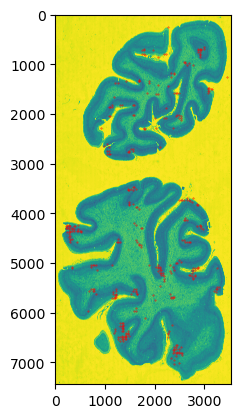

In [12]:
plt.imshow(image_1[0])
plt.scatter(matches_image_1[:, 0], matches_image_1[:, 1], s=.1, c="r")

In [32]:
matches_image_1.shape

torch.Size([8127, 2])

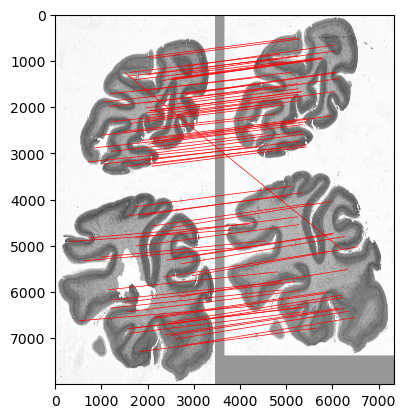

In [31]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, image_2_visualization_adjusted, matches_image_1[::100], matches_image_2[::100])

In [20]:
from source.miscellaneous.evaluation import evaluate_test_image_pair

In [13]:
(
    number_of_matches,
    average_distance,
    match_precision,
    auc,
    matches_per_patch,
    entropy,
) = evaluate_test_image_pair(matches_image_1, matches_image_2, deformation)
print(
    f"Number of matches: {number_of_matches}\nAverage distance: {average_distance}\nAUC: {auc}\nEntropy: {entropy}"
)

NameError: name 'evaluate_test_image_pair' is not defined

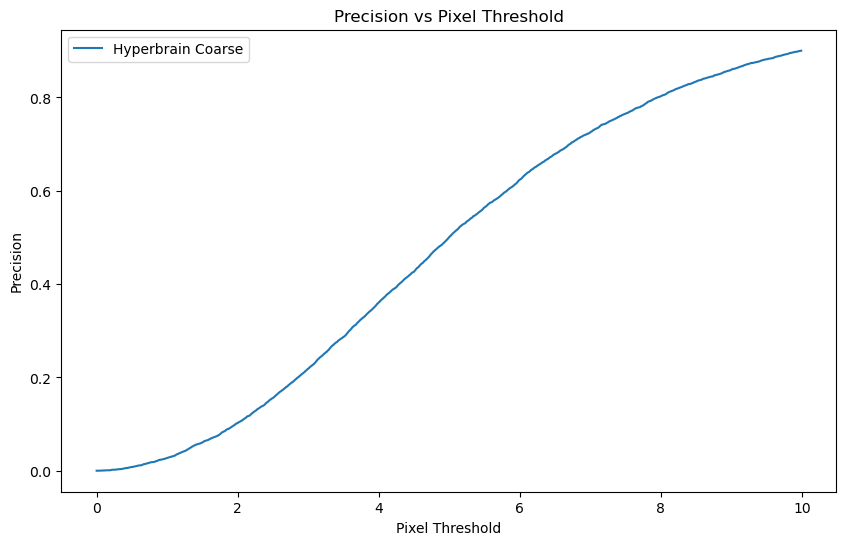

In [35]:
from source.visualization.evaluation_visualization import *
plot_precision_vs_threshold(match_precision, labels=["Hyperbrain Coarse"])

In [14]:
matches = torch.column_stack([matches_image_1, matches_image_2])

In [15]:
torch.save(matches, f"../../models/coarse_matching/{model_name}/matches_test.pt")